# Intelligent agents in Scenario Gym
This notebook covers the process of creating custom intelligent agents in Scenario Gym.

In [2]:
import sys, os

import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import Output, GridspecLayout
from IPython import display

import scenario_gym
scenario_base_path = os.path.join("../tests/input_files/Scenarios")
paths = [
    os.path.join(scenario_base_path, f)\
    for f in os.listdir(scenario_base_path) if "xosc" in f
]

## Toolchain Pipeline

1. Load and inspect a scenario
2. Inspect road network and available layers
3. Setup parameters
4. Create and add agents
5. Define and add metrics
6. Scenario rollout
7. View results
8. Run scenarios in bulk

## Scenarios
The Scenario Gym runs scenarios from OpenScenario files. These are loaded to a `Scenario` object which can be accessed via the global state e.g. `gym.state.scenario`.

In [3]:
gym = scenario_gym.ScenarioGym()
scenario_path = paths[0]
gym.load_scenario(scenario_path)
scenario = gym.state.scenario

The scenario consists of a list of entities and a road network. We can plot the scenario with `scenario.plot()` and get a text description of the scenario with `scenario.describe()`.

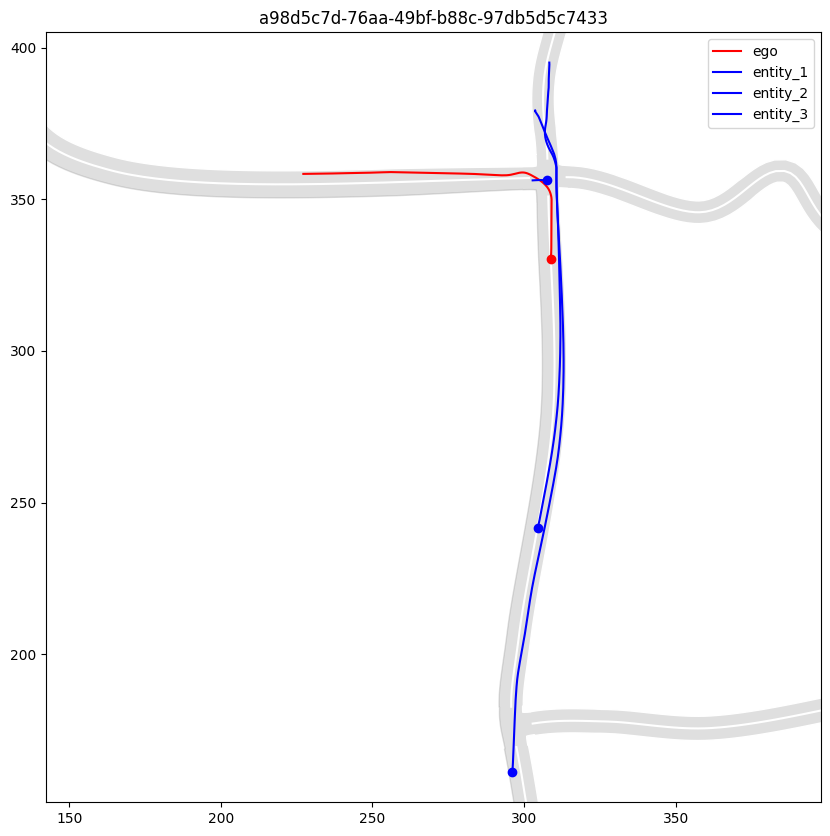

In [4]:
scenario.plot()

In [5]:
scenario.describe()


Scenario: a98d5c7d-76aa-49bf-b88c-97db5d5c7433
Road network: Rural_Road_Network
Number of entities: 4
Total duration: 28.84s

Entities
--------
Entity    Type      Cateogry  
ego       Vehicle   car       
entity_1  Vehicle   car       
entity_2  Vehicle   car       
entity_3  Vehicle   car       




Specific entity or road network data can be accessed via the individual objects. For example the road network:

In [16]:
rural_road_net = '/home/tsl/Projects/tools/simulation/scenario_gym/tests/input_files/Road_Networks/Rural_Road_Network.json'


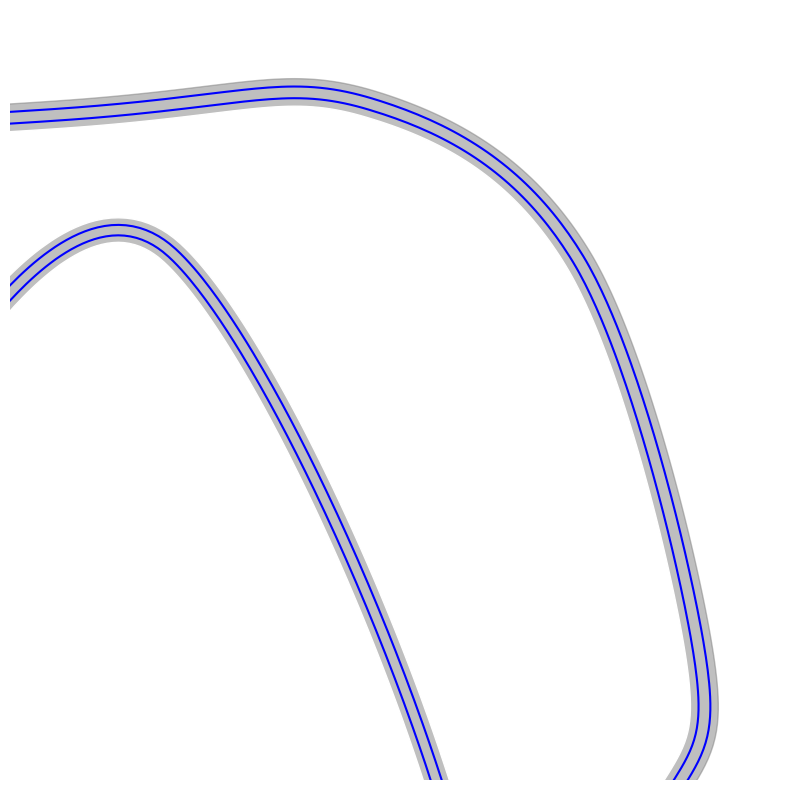

In [17]:

# rn_filepath = scenario.road_network.path
rn_filepath = rural_road_net
road_network = scenario_gym.RoadNetwork.create_from_json(rn_filepath)

plt.figure(figsize=(10, 10))

# plot the driveable surface
for geom in road_network.driveable_surface.geoms:
    plt.fill(*geom.exterior.xy, c='gray', alpha=0.5)
    for i in geom.interiors:
        plt.fill(*i.xy, c='white')
        
# plot the lane centers
for x in road_network.roads + road_network.intersections:
    for l in x.lanes:
        plt.plot(*l.center.xy, c='b')
    
plt.xlim(350, 600)
plt.ylim(400, 650)
plt.axis("off")
plt.show()

The `Scenario` object contains only static information from the scenario i.e. no simulation specific data such as the current time or positions of each entity. These are accessed via 
the `State`. The state holds the current time as well as positions, velocities and historical positions of each entity.

In [19]:
ego = scenario.entities[0]
gym.state.t, gym.state.poses[ego], gym.state.velocities[ego]

(6.32,
 array([3.087547e+02, 3.304671e+02, 3.441520e+01, 1.376900e+00,
        2.630000e-02, 1.107000e-01]),
 array([-0.001,  0.001, -0.002, -0.001,  0.   , -0.001]))

The `State` also has helpful methods to access entities in specific areas of the road network:

In [ ]:
# get entities with 10m of the ego 
gym.state.get_entities_in_radius(*gym.state.poses[ego][:2], 10)

In [ ]:
# get entities on a particular road 
gym.state.get_entities_in_area(scenario.road_network.roads[3].boundary)

In [ ]:
# get the road for a particular entity
gym.state.get_road_info_at_entity(scenario.entities[0])

## Gym setup
To setup our environment in the way we want there are a various settings available in the gym that can be configured (before implementing agents). This section covers these parameters.

### Timestep
At each step the Scenario Gym increments the current time by a fixed amount (`gym.timestep`) and updates positions for all entities. This should be set to the desired level to balance computation and precision. Too low a value will mean many more steps per scenario and too high a value will lead to inaccurate simulation.

In [22]:
gym.timestep

0.03333333333333333

### Terminal conditions
We will want to define when our scenario is considered to have finished. We can configure this with the `terminal_conditions` parameter.

Terminal conditions determine when the scenario has finished and are stored as part of the state: `state.terminal_conditions`. A state may have multiple conditions and is considered terminal when any of them are met. For example we may end the scenario when a collision occurs or if we reach a time limit. By default the scenario will end when the maximum time from its OpenScenario file is reached.

These are implemented as simple callables taking the state as argument and returning a boolean. As an example below is condition that ends the scenario after a minute:

In [ ]:
def end_after_a_minute(state):
    return state.t > 60.

Some common conditions are provided and can be used by supplying their string identifier:

In [23]:
from scenario_gym.state import TERMINAL_CONDITIONS
list(TERMINAL_CONDITIONS)

['max_length', 'collision', 'ego_collision', 'ego_off_road']

* `max_length` ends when the maximum time from the OpenScenario is reached. This is the default condition.
* `collision` ends if there is a collision between any two entities.
* `ego_collision` ends if there is a collision between the ego and another entity.
* `ego_off_road` ends when the ego leaves the `driveable_surface` layer of the road network.

### Rendering and recording
The Scenario Gym can render scenarios as videos and record them to OpenScenario files. To run a scenario once it is loaded with the requried settings we call `gym.rollout()`.

We can render the scenario as a video by passing `render=True` to rollout. By default this will look for a recordings folder at the same level as the scenario's directory but we can give it a custom path by passing `video_path=...` to rollout. There are several parameters that control the rendering which can be seen in `scenario_gym.viewer.Viewer`.

To output an OpenSCENARIO of the recorded simulation we convert the gym state to a scenario:
```
new_scenario = gym.state.to_scenario()
```
Then we can write this to OpenSCENARIO:
```
from scenario_gym.xosc_interface import write_scenario

write_scenario(new_scenario, output_path)
```

## Agents, sensors and controllers
Agents are implemented in the Scenario Gym through three modules: `Sensor`, `Agent` and `Controller`. These manage the process for generating the observation, producing the action and updating the entity state:
* the `Sensor` produces an `Observation` from the `State`,
* the `Agent` recieves the observation and returns an `Action`,
* the `Controller` updates the agent's pose and internal state from the action.
The interface of each object requires a `_reset` and `_step` method to be implemented. The `_reset` method resets the internal state of each object at the start of a scenario. The `_step` method implements each object's part of the process.

### Sensors
The sensor module produces observations from the state. It takes the full global state as input and produces the local information which is available to the agent. 

An example sensor already implemeted in the Scenario Gym is the `RasterizedMapSensor` which returns an observation in the form of an array representation of the area around the agent with shape `(width, height, layers)`. The layers are semantic layers of the scene such as the driveable surface or the bounding boxes of nearby entities.

In [24]:
from scenario_gym.sensor import RasterizedMapSensor
sensor = RasterizedMapSensor(
    gym.state.scenario.entities[0],
    layers=["entity", "driveable_surface"],
    height=20.,
    width=20.,
    freq=10,
)
print(f"Rasterized map shape: {sensor.output_shape}")

Rasterized map shape: (200, 200, 2)


This sensor has two layers. Here is what it produces at `t = 9` in the current scenario:

In [30]:
type(gym.state)

scenario_gym.state.state.State

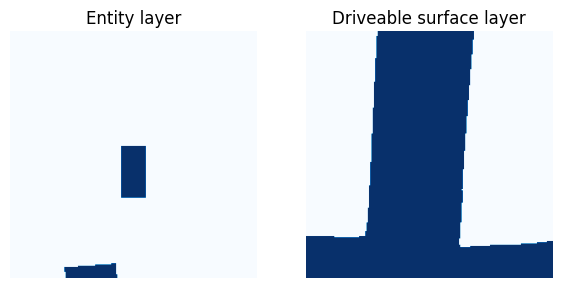

In [32]:
gym.reset_scenario()
_ = sensor.reset(gym.state)
for i in range(30 * 9):
    gym.step()

obs = sensor.step(gym.state)


f, ax = plt.subplots(figsize=(7, 5), ncols=2)
ax[0].imshow(np.flip(obs.map[...,0]), cmap='Blues')
ax[1].imshow(np.flip(obs.map[...,1]), cmap='Blues')
ax[0].axis("off")
ax[1].axis("off")
ax[0].title.set_text("Entity layer")
ax[1].title.set_text("Driveable surface layer")
plt.show()

### Custom Sensors
To implement a custom sensor we implement the `_reset` and `_step` methods. The output produced by the sensor should be local to the entity it represents. The sensor can access its entity at any time via `sensor.entity`. From this and the state it can access for example the position or velocity of its entity: `state.poses[sensor.entity]`, `state.velocities[sensor.entity]`.

In [ ]:
from scenario_gym import Entity, State, Observation, Sensor

class CustomSensor(Sensor):

    def __init__(self, entity: Entity):
        """
        Assign any fixed parameters here.
        """
        super().__init__(entity)

    def _reset(self) -> Observation:
        """
        Reset any scenario dependent parameters here and return initial obs.
        """
        inital_obs = ...
        return initial_obs

    def _step(self, state: State) -> Observation:
        """
        Generate the observation for the entity from the global state here.
        """
        observation = ...
        return observation


As an example, the sensor below will detect entities within a distance ahead of the ego:

In [ ]:
from shapely.geometry import Polygon, LineString
from typing import List

class ForwardSensor(Sensor):
    """Detects entities a distance ahead of the entity."""
    
    def __init__(self, entity: Entity, distance: float = 10.):
        super().__init__(entity)
        self.distance = distance
    
    def _reset(self, state: State) -> List[Entity]:
        return self._step(state)
    
    def _step(self, state: State) -> List[Entity]:
        # get a vector in the direction of the entity's heading
        pose = state.poses[self.entity]
        h = pose[3]
        vec = np.array([np.cos(h), np.sin(h)])
        
        # get a Polygon covering the area
        area = LineString([
            pose[:2],
            pose[:2] + vec * self.distance,
        ]).buffer(2.)
        
        # return any other entities within that area
        ents = state.get_entities_in_area(area)
        return [e for e in ents if e != self.entity]

### Controllers
The controller processes the agent's action to update the global state. It is responsible for managing the physical model of the entity and updating it after the agent's action. For example, our agent may produce vehicle actions such as a steering velocity and an acceleration which we decode via a kinematic model to update the entity's position.

The Scenario Gym package includes a several vehicle controllers:
* `VehicleController`: uses a physical model to control the motion of a vehicle and respond to vehicle actions (accerlation and steering).
* `BasicVehicleController`: controls a vehicle with very simple dynamics and minimal physical constraints.
* `PIDController`: uses PID control and a vehicle model to follow waypoint actions.

### Custom controllers
We implement controllers in a similar manner to the sensor. The controller will take the state and action and should update its internal state and return the new pose for the entity. After all the gym has gathered the new poses for all entities it will update the global state for advance the timestamp.

In [ ]:
from scenario_gym import Entity, Controller, State, Action

class CustomController(Controller):

    def __init__(self, entity: Entity):
        """
        Assign any fixed parameters here.
        """
        super().__init__(entity)

    def _reset(self, state: State) -> None:
        """
        Reset any scenario dependent parameters here.
        """
        pass

    def _step(self, state: State, action: Action) -> "Pose":
        """
        Update the controller internal state and return the next pose.
        """
        next_pose = ...
        return next_pose

### Agents
An agent controls a single entity. It has a sensor to provide local observations from which the agent selects an action and a controller which process the action to update the entity's position. Each agent stores the reference to its sensor and controller so are constructed as:

`agent = Agent(entity, sensor, controller)`.

The `_step` must be implemented for each agent and will produce the chosen action from each observation. The `step` method of the agent will then handle the calls to each module:
```python
class Agent:
    ...
    def step(self, state):
        obs = self.sensor.step(state)
        action = self._step(obs)
        next_pose = self.controller.step(state, action)
        return next_pose
```
Along with the `_step` method, each agent must also implement `_reset`:

In [ ]:
from scenario_gym import Agent, Action, Controller, Entity, Observation, Sensor, State

class CustomAgent(Agent):

    def __init__(self, entity: Entity, controller: Controller, sensor: Sensor):
        """
        Assign any fixed parameters here.
        """
        super().__init__(entity, controller, sensor)

    def _reset(self) -> None:
        """
        Reset any scenario dependent parameters here.
        """
        pass

    def _step(self, observation: Observation) -> Action:
        """
        Select an action from the observation.
        """
        action = ...
        return action

When implementing agents we must decide the sensor and controller that they will use which will determine their observation and action spaces. Then we implement the `_step` method. Since we pass the sensor and controller to the agent's constructor we can define them in the constructor of our subclass. For example, below shows a vehicle agent that takes a rasterized map representation as observation, selects acceleration and steering values via a neural network and then passes these to a vehicle controller.

In [ ]:
import torch
import torch.nn as nn
from scenario_gym.action import VehicleAction
from scenario_gym.controller import VehicleController
from scenario_gym.sensor import RasterizedMapSensor

class NeuralAgent(Agent):
    """An agent controlled by a given neural network."""
    
    def __init__(self, entity: Entity, network: nn.Module):
        self.network = network
        controller = VehicleController(entity)
        sensor = RasterizedMapSensor(entity)
        super().__init__(
            entity,
            controller,
            sensor,
        )
    
    def _reset(self):
        pass
    
    def _step(self, observation):
        observation = torch.from_numpy(observation)
        with torch.no_grad():
            output = self.network(observation)
        accel, steer = output.numpy()
        return VehicleAction(accel, steer)

## Metrics
When running scenarios we will want to measure different quantities and look out for various events. We can do this with the `Metric` object. This implements the `step` and `reset` methods similarly to the agent. The step method is called after every timestep for the metric to update its internal state e.g. to update a running mean. After the scenario we call `metric.get_state()` to return the metric's value and then `metric.reset()` to prepare for the next scenario.

To define a metric we implement `_reset`, `_step` and `get_state`. Then we add the metric to the gym before running any scenarios. We should remember to call `metric.get_state` after the scenario has finished and record the result.

In [ ]:
from scenario_gym.metrics import Metric
class EgoSpeedMetric(Metric):
    """Compute the average speed of the ego."""
    
    def _reset(self, state):
        self.ds = 0.
        self.t = 0.
    
    def _step(self, state):
        ego = state.scenario.entities[0]
        self.ds += np.linalg.norm(state.velocities[ego][:2]) * state.dt
        self.t = state.t
        
    def get_state(self):
        return self.ds / self.t if self.t > 0 else 0.

We can then add the metric to the gym and rollout the scenario:

In [ ]:
metric = EgoSpeedMetric()
gym = scenario_gym.ScenarioGym(metrics=[metric])
gym.load_scenario(paths[0])
gym.rollout()
result = metric.get_state()
print(f"Ego average speed: {result:.4}.")

## Scenario rollouts
Once we have implemented our intelligent agents and defined our metrics we are ready to run scenarios. Before running we need to assign agents to the relevant entities. This is important since This is done by defining a function to create an agent for any given entity which will be called for each entity in the scenario. This function should have the signature: `(scenario, entity) -> Optional[Agent]`. The output can be `None` since we do not have to assign an agent to each entity. If we don't then the entity will follow its predefined trajectory.

We pass our function when loading the scenario to the gym: 
```python
def create_agent(s, e) -> Optional[Agent]:
    ...
    
gym.load_scenario(filepath, create_agent=create_agent)
```
To determine the correct agent to use for each entity we can use entity characteristics e.g. the type or category, or the unique reference (`e.ref`). After this we can rollout the scenario. For example we could assign the neural agent to the ego, another to all pedestrians and leave all other entities:
```python
def create_agent(scenario: Scenario, entity: Entity) -> Optional[Agent]:
    """"""
    if entity.ref == "ego":
        return NeuralAgent(...)
    elif entity.type == "Pedestrian":
        return PedestrianAgent(...)
``` 
We can inspect our agents after we have loaded the scenario:

In [33]:
gym.state.agents

{<scenario_gym.entity.vehicle.Vehicle at 0x7f9e536544c0>: <scenario_gym.agent.ReplayTrajectoryAgent at 0x7f9e52a74d90>}

Now we can rollout the scenario:

In [ ]:
gym.rollout(render=True, video_path="./example1.mp4")
display.Video("./example1.mp4", embed=True, width=512)

We can change the rendering behaviour by modifying the `viewer_parameters`. For example to display all road and lane centers:

In [ ]:
gym.viewer_parameters["render_layers"] = ["driveable_surface", "road_centers"]
#gym.viewer_parameters["background_color"] = 
gym.rollout(render=True, video_path="./example2.mp4")
display.Video("./example2.mp4", embed=True, width=512)

## Advanced Usage
### State callbacks
Often when creating intelligent agents we will need to derive are provide extra data from the global state that is not included in the scenario by default. For example we may want to simulate a scene with traffic signals which are not provided in the OpenScenario file. We could incorporate this when we implement our agent e.g. via its sensor module however if we have many agents which all need access to this information this may not be efficient. An alternative is to use the `state_callbacks` parameter of the Scenario Gym. This takes callables which take the state as input and modify it inplace. These are called every step to provide additional information without repeating computation. For example below we provide an additional parameter to the state giving the colour of a traffic light.

In [ ]:
from scenario_gym.callback import StateCallback

class TrafficLightCallback(StateCallback):

    def _reset(self, state):
        self.color = "Green"
    
    def __call__(self, state):
        t = state.t % 60. 
        if t < 20.:
            self.color = "Green"
        elif t < 30.:
            self.color = "Yellow"
        else:
            self.color = "Red"

This is passed to the Scenario Gym constructor and then will be called whenever the timestamp is updated:

In [ ]:
gym = scenario_gym.ScenarioGym(state_callbacks=[TrafficLightCallback()])
gym.load_scenario(paths[0])
gym.rollout()
print(f"Current light colour: {gym.state.state_callbacks[0].color}.")

### Running scenarios in bulk with the scenario manager
To better manage running scenarios in bulk we can use the `ScenarioManager` class. This class will help us store all of the parameters and metrics and run multiple scenarios. We just overwrite the `create_agent` method of the class.

In [ ]:
from scenario_gym.manager import ScenarioManager
from scenario_gym.agent import ReplayTrajectoryAgent

class Manager(ScenarioManager):
    
    def create_agent(self, scenario, entity):
        if entity.ref == "ego":
            return ReplayTrajectoryAgent(
                entity,
                scenario_gym.controller.ReplayTrajectoryController(entity),
                scenario_gym.sensor.EgoLocalizationSensor(entity),
            )

When we initialize the scenario manager we pass any gym or rendering parameters and any additional custom parameters. Then we can add any metrics.

In [ ]:
manager = Manager(timestep=0.1, custom_parameter=2.)

manager.add_metric(EgoSpeedMetric())

Then we can run scenarios:

In [ ]:
results = manager.run_scenarios(paths[:5])
print(f"Ego average speed across scenarios: {np.mean(results):.4}")

### Custom scenarios
In some cases we may want to modify the scenarios before running them through the gym or to create new ones entirely. We do this by either loading the scenario from OpenScenario or creating it and then using the `gym._set_scenario` method to attach it to the gym.

If we wish to edit an existing scenario then we can load it from apply modifications to it after loading it via `gym.load_scenario`. For example we could vary the timing of an entity's trajectory. Here we add 1 second to each control point of the second entity:

In [ ]:
from scenario_gym.xosc_interface import import_scenario
gym = scenario_gym.ScenarioGym()

scenario = import_scenario(paths[0])

entity = scenario.entities[1]
new_traj = entity.trajectory.translate(np.array([1., 0, 0, 0, 0, 0, 0]))
entity.trajectory = new_traj

gym.set_scenario(scenario)

We can also create a scenario programatically. We just need to load the required components e.g. catalog information and road networks and then define trajectories. Below we create a trajectory with a single entity moving along the y-axis. We could also have created our entity by defining a custom catalog entry.

In [ ]:
from scenario_gym.xosc_interface import read_catalog
from scenario_gym.scenario import Scenario
from scenario_gym.trajectory import Trajectory
from scenario_gym.road_network import RoadNetwork
from copy import deepcopy

# load a road network
road_network = RoadNetwork.create_from_json(
    "../tests/input_files/Road_Networks/Greenwich_Road_Network_002.json"
)

# create a bcar1` entity
_, catalogs = read_catalog("../tests/input_files/Catalogs/Scenario_Gym/VehicleCatalogs/ScenarioGymVehicleCatalog.xosc")
e = deepcopy(catalogs["car1"])
e.ref = "ego"

# define its trajectory
e.trajectory = Trajectory(
    np.array([
        [1., 0., 1.],
        [2., 0., 2.],
        [3., 0., 3.],
    ]),
    fields=["t", "x", "y"],
)

# add the entity
entities = [e]

scenario = Scenario(entities, road_network=road_network, name="example_scenario")

gym.set_scenario(scenario)
gym.rollout()